In [ ]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

#/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/

In [1]:
import os
import torch
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
mkdir train test

In [3]:
import os
import shutil
import random

# Define paths
parasitized_folder = '/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/'
uninfected_folder = '/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/'
train_folder = '/kaggle/working/train'
test_folder = '/kaggle/working/test'

# Create train and test folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

train_parasitized = os.path.join(train_folder, 'parasitized')
train_uninfected = os.path.join(train_folder, 'uninfected')
test_parasitized = os.path.join(test_folder, 'parasitized')
test_uninfected = os.path.join(test_folder, 'uninfected')

os.makedirs(train_parasitized , exist_ok=True)
os.makedirs(train_uninfected, exist_ok=True)
os.makedirs(test_parasitized, exist_ok=True)
os.makedirs(test_uninfected, exist_ok=True)

# Define the split ratio (e.g., 80% train, 20% test)
split_ratio = 0.75

# # Function to distribute images
def distribute_images(source_folder, train_subfolder, test_subfolder, split_ratio):
    images = os.listdir(source_folder)
    random.shuffle(images)
    split_index = int(len(images) * split_ratio)
    
    for i, image in enumerate(images):
        if i < split_index:
            shutil.copy(os.path.join(source_folder, image), os.path.join(train_subfolder, image))
        else:
            shutil.copy(os.path.join(source_folder, image), os.path.join(test_subfolder, image))

# # Distribute images from soft folder
distribute_images(parasitized_folder, train_parasitized, test_parasitized, split_ratio)

# # Distribute images from hard folder
distribute_images(uninfected_folder, train_uninfected, test_uninfected, split_ratio)

print("Images have been distributed into train and test folders with subfolders.")

Random image path: /kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C177P138NThinF_IMG_20151201_142942_cell_170.png
Image class: Parasitized
Image height: 106
Image width: 106


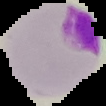

In [4]:
import random
from PIL import Image
from pathlib import Path

random.seed(23) 
image_path = Path('/kaggle/input/cell-images-for-detecting-malaria/cell_images/')

image_path_list = list(image_path.glob("*/*.png"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [5]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# transform for images
data_transform = transforms.Compose([
    transforms.Resize(size=(60, 60)),
    transforms.ToTensor() 
])

In [ ]:
# Using ImageFolder to create datasets
train_data = datasets.ImageFolder(root=train_folder, 
                                  transform=data_transform, 
                                  target_transform=None) 

test_data = datasets.ImageFolder(root=test_folder, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

In [65]:
# Get class names as a list
class_names = train_data.classes
class_names

['parasitized', 'uninfected']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

In [ ]:
len(train_data), len(test_data)

In [ ]:
BATCH_SIZE = 1000
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=True) 

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

In [ ]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

In [52]:
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt

In [ ]:
# Visualize sample images in dataset

def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # Set random seed
    if seed:
        random.seed(seed)

    # Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 8))

    # Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # Adjust image tensor shape for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

In [ ]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=6, 
                      classes=class_names,
                      seed=None)

In [ ]:
class MalariaDetectionModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block = nn.Sequential(
                                    nn.Conv2d(in_channels=input_shape, 
                                              out_channels=hidden_units, 
                                              kernel_size=3, 
                                              stride=1, 
                                              padding="valid"), 
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.Conv2d(in_channels=hidden_units, 
                                              out_channels=128,
                                              kernel_size=3,
                                              stride=1,
                                              padding="valid"),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2) 
                                )
        
        self.classifier = nn.Sequential(
                                nn.Flatten(),
                                
                                nn.Linear(in_features=128*13*13,
                                          out_features=32),
                                nn.ReLU(),
                                nn.Linear(in_features=32,
                                          out_features=16),
                                nn.ReLU(),
                                nn.Linear(in_features=16,
                                          out_features=1),
                                nn.Sigmoid()
                            )
        
    
    def forward(self, x: torch.Tensor):
        x = self.classifier(self.conv_block(x))
        return x 

torch.manual_seed(42)
model = MalariaDetectionModel(input_shape=3, 
                              hidden_units=64, 
                              output_shape=1).to(device)
model

In [ ]:
from torchinfo import summary
summary(model, input_size=[1, 3, 60, 60]) 

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.sigmoid(pred)}\n")
print(f"Output prediction label:\n{(torch.sigmoid(pred) >= 0.5).int()}\n")
print(f"Actual label:\n{label_single}")

In [39]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X).squeeze(dim=1)

        # Calculate and accumulate loss
        # y should be of shape (batch_size, 1) and of type float32
        loss = loss_fn(y_pred, y.float())
        train_loss += loss.item() 

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Apply sigmoid to y_pred to get probabilities
        y_pred_probs = torch.sigmoid(y_pred)
        # Convert probabilities to predicted class (0 or 1) using a threshold of 0.5
        y_pred_class = (y_pred_probs >= 0.5)
        # print(y_pred_class)
        # Calculate accuracy
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [40]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X).squeeze(dim=1)
            
            # Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y.float())
            test_loss += loss.item()
            
            # Apply sigmoid to logits to get probabilities
            test_pred_probs = torch.sigmoid(test_pred_logits)
            
            # Convert probabilities to predicted class (0 or 1) using a threshold of 0.5
            test_pred_labels = (test_pred_probs >= 0.5)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [41]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.BCEWithLogitsLoss(),
          epochs: int = 10):
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # Loop through training and testing steps 
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer, device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        # Print results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    return results

In [ ]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, eps=1e-8)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [53]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Number of epochs
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

In [ ]:
plot_loss_curves(model_0_results)

# Transfer Learning with EfficientNet

In [ ]:
import torch, torchvision
from torchinfo import summary

In [6]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Reshape all images to 224x224 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]) 
])

In [7]:
# Use ImageFolder to create datasets
train_data = datasets.ImageFolder(root=train_folder, 
                                  transform=manual_transforms,images)
                                  target_transform=None) 

test_data = datasets.ImageFolder(root=test_folder, 
                                 transform=manual_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 20669
    Root location: /kaggle/working/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 6889
    Root location: /kaggle/working/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [8]:
BATCH_SIZE = 1000 #number of samples per batch
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS,
                              shuffle=True) 

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

In [72]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [11]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [73]:
summary(model=model, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [74]:
# Freeze all base layers in the model's the feature extractor
for param in model.features.parameters():
    param.requires_grad = False


In [75]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=1, # since it's binary classification
                    bias=True)).to(device)

In [76]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [77]:
# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("[INFO] Couldn't find tensorboard... installing it.")
    !pip install -q tensorboard
    from torch.utils.tensorboard import SummaryWriter


# Create a writer with all default settings
writer = SummaryWriter()

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.BCEWithLogitsLoss(),
          epochs: int = 10):
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # Loop through training and testing steps 
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer, device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        # Print results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)


          ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    return results

In [80]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=40)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1990 | train_acc: 0.9283 | test_loss: 0.1854 | test_acc: 0.9345
Epoch: 2 | train_loss: 0.1961 | train_acc: 0.9288 | test_loss: 0.1834 | test_acc: 0.9358
Epoch: 3 | train_loss: 0.1947 | train_acc: 0.9280 | test_loss: 0.1818 | test_acc: 0.9374
Epoch: 4 | train_loss: 0.1916 | train_acc: 0.9298 | test_loss: 0.1785 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.1930 | train_acc: 0.9314 | test_loss: 0.1792 | test_acc: 0.9394
Epoch: 6 | train_loss: 0.1944 | train_acc: 0.9287 | test_loss: 0.1776 | test_acc: 0.9374
Epoch: 7 | train_loss: 0.1904 | train_acc: 0.9299 | test_loss: 0.1775 | test_acc: 0.9397
Epoch: 8 | train_loss: 0.1886 | train_acc: 0.9320 | test_loss: 0.1764 | test_acc: 0.9393
Epoch: 9 | train_loss: 0.1886 | train_acc: 0.9318 | test_loss: 0.1755 | test_acc: 0.9410
Epoch: 10 | train_loss: 0.1862 | train_acc: 0.9317 | test_loss: 0.1768 | test_acc: 0.9393
Epoch: 11 | train_loss: 0.1879 | train_acc: 0.9318 | test_loss: 0.1759 | test_acc: 0.9403
Epoch: 12 | train_l

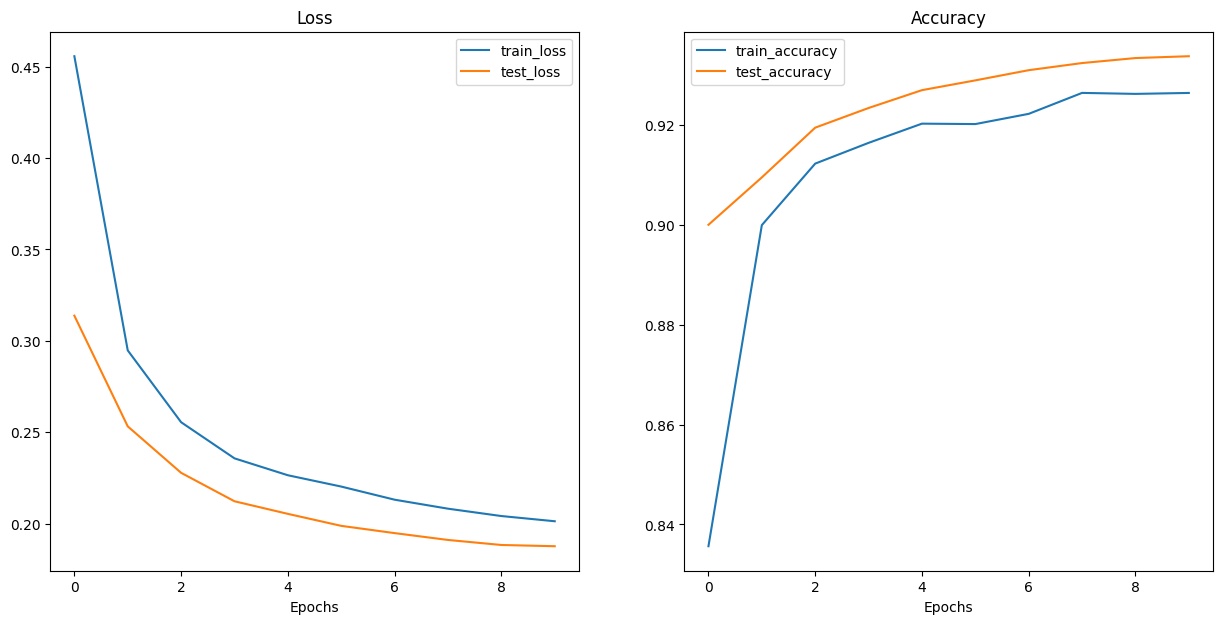

In [79]:
plot_loss_curves(results)

In [56]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    img = Image.open(image_path)
    
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])


    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0)
      target_image_pred = model(transformed_image.to(device))
      target_image_pred_probs = torch.sigmoid(target_image_pred)
      
      # Convert probabilities to predicted class (0 or 1) using a threshold of 0.5
      target_image_pred_label = (target_image_pred_probs >= 0.5)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

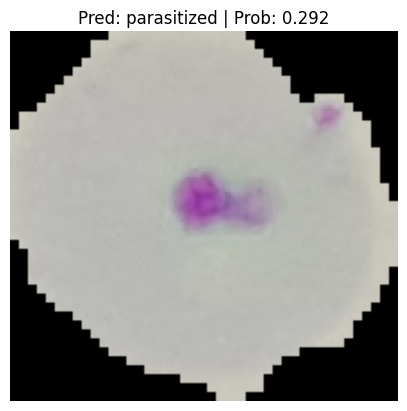

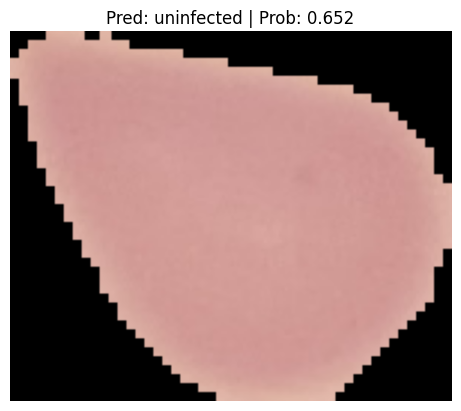

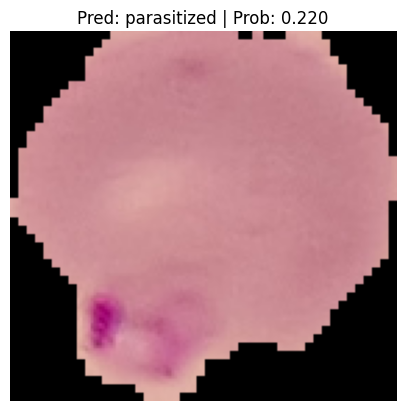

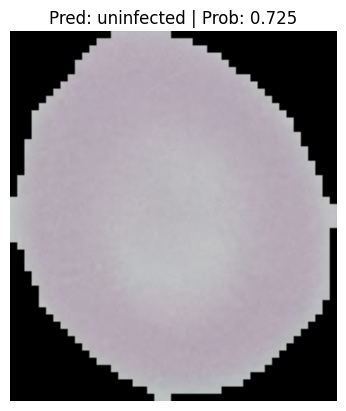

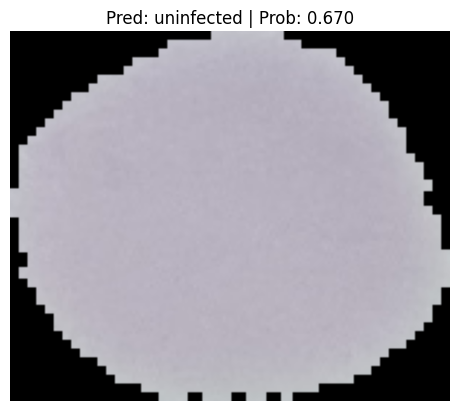

In [67]:
# Testing the model on random images in test dataset
import random
num_images_to_plot = 5
test_image_path_list = list(Path(test_folder).glob("*/*.png")) 
test_image_path_sample = random.sample(population=test_image_path_list, 
                                       k=num_images_to_plot) 

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

In [68]:
#Saving the malaria detection model
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [71]:
save_model(model=model,
           target_dir='/kaggle/working/model',
           model_name="malaria_model.pt")

[INFO] Saving model to: /kaggle/working/model/malaria_model.pt
